## Building a model to train on MNIST

For now: 
(1) Custom Top-down i.e burstccn mimicking neural network; 
- Flatten function, x (3) hidden layers of y (500) units, an output layer
- Layers: custom linear layers, as done in BurstCCN (if I understood well) 
- Activation functions: sigmoids as done in BurstCCN 
- Loss: Pytorch MSEloss for the moment (can further be complexified as the sum of 2 cost function ponderated by a factor each). 
- Gradient computation done using Pytorch loss directly --> may custom 
- Optimizer step: Pytorch SGD for the moment  
(2) Custom Self-supervised network
- Represent PV cells synapsing onto Pyr cells
- class PV (i.e. the L23 of neoSSL) and class Pyr (i.e class L5 of the neoSSL)
- Both classes receive Thalamic input, PV forward predictions into Pyr that gives feedback (teaching signal) to PV --> instruct the PV edictive model

Aim Features: 
- global cost function --> SST IN
- local cost function --> PV IN

Modules:

In [1]:
import os
import torch
import torchvision

/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E943EB88-577E-37A4-93E1-5DAFE97B5744> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Load MNIST dataset

In [3]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 32
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

In [4]:
print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


## Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
from modules.network import NeuralNetwork, Net
n_hidden_layers = 3
n_hidden_units = 500  # number of units per hidden layer
n_inputs = 28*28 # size of input images (28*28)
n_outputs = 10 # number of classes

model = NeuralNetwork(n_inputs= n_inputs,
                      n_outputs=n_outputs,
                     n_hidden_layers=n_hidden_layers,
                      n_hidden_units=n_hidden_units)


# model = Net()


In [7]:
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Flatten()
    (1): HiddenLayer(input_dim=784, output_dim=500)
    (2): HiddenLayer(input_dim=500, output_dim=500)
    (3): HiddenLayer(input_dim=500, output_dim=500)
    (4): OutputLayer(input_dim=500, output_dim=10)
  )
)


In [8]:
dummy_input = torch.randn(1, 1, 28, 28)
model(dummy_input)

tensor([[0.5080, 0.5067, 0.4311, 0.5309, 0.4892, 0.4765, 0.4445, 0.4279, 0.4932,
         0.4279]], grad_fn=<SigmoidBackward0>)

## Initialisation

In [9]:
from modules.optimizer import SGDOptimizer, AdamOptimizer

learning_rate = 0.1 #0.4 when using CrossEntropyLoss cost function
momentum = 0.5

# optimizer = SGDOptimizer(model.parameters(), lr=learning_rate)
# optimizer = AdamOptimizer(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
n_epochs = 1
log_interval = 200

## Loss trial

In [22]:
builtin_losses = []
mse_losses = []


def train_loss(epoch, data_loader):
  model.train()
  for batch_idx, (data, target) in enumerate(data_loader):
    optimizer.zero_grad()
    output = model(data)
    t = F.one_hot(target, num_classes=10).float() # only if MSEloss
    builtin_loss = model.loss(output, t)
    mse_loss = model.MSE_loss(output, t)
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBuiltin Loss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(data_loader.dataset),
      100. * batch_idx / len(data_loader), builtin_loss.item()))
      print("custom loss:", mse_loss)
      builtin_losses.append(builtin_loss.item())
      mse_losses.append(mse_loss)
  return builtin_losses, mse_losses


In [23]:
for epoch in range(1, n_epochs + 1):
  train_loss(epoch, train_data_loader)


AttributeError: 'NeuralNetwork' object has no attribute 'MSE_loss'

## Training

In [8]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(n_epochs + 1)]
# criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()

def train(epoch, data_loader):
  model.train()
  for batch_idx, (data, target) in enumerate(data_loader):
    optimizer.zero_grad()
    output = model(data)
    t = F.one_hot(target, num_classes=10).float() # only if MSEloss
    loss = model.loss(output, t)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(data_loader.dataset),
      100. * batch_idx / len(data_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(data_loader.dataset)))
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')


def test(data_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      t = F.one_hot(target, num_classes=10).float() # only if MSEloss
      loss = model.loss(output, t)
      test_loss += loss.item() 
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss = test_loss / len(data_loader.dataset) * batch_size_test
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [9]:
test(test_data_loader)
for epoch in range(1, n_epochs + 1):
  train(epoch, train_data_loader)
  test(test_data_loader)


Test set: Avg. loss: 0.2310, Accuracy: 1010/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.231909
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.089790
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.089871
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.089909

Test set: Avg. loss: 0.0900, Accuracy: 1010/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.089684
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.089780
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.089996
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.090198

Test set: Avg. loss: 0.0900, Accuracy: 1135/10000 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.090089
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.090349
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.090086
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.090072

Test set: Avg. loss: 0.0899, Accuracy: 1032/10000 (10%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.090170
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.088406
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.090184
Train Epoch: 4 [48000/60000 (80%)]	Los

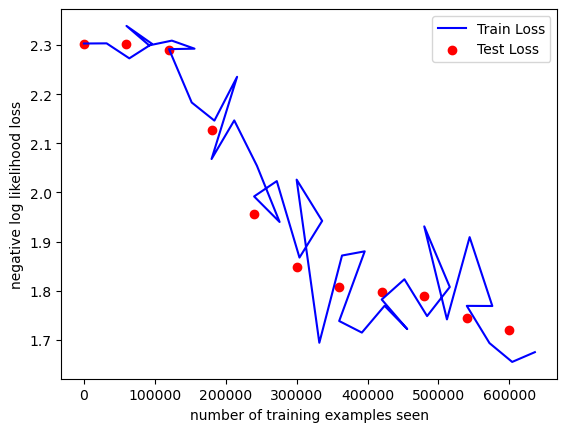

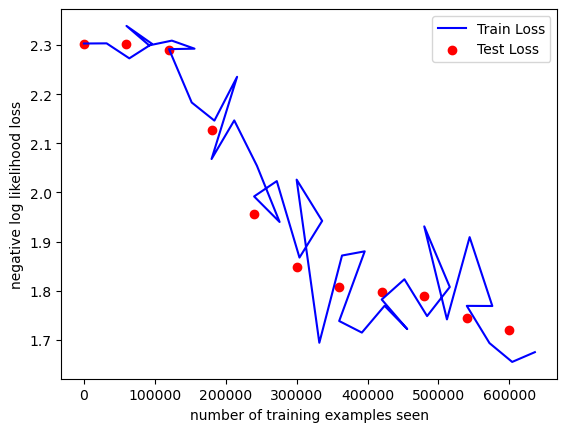

In [142]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Loss')
fig

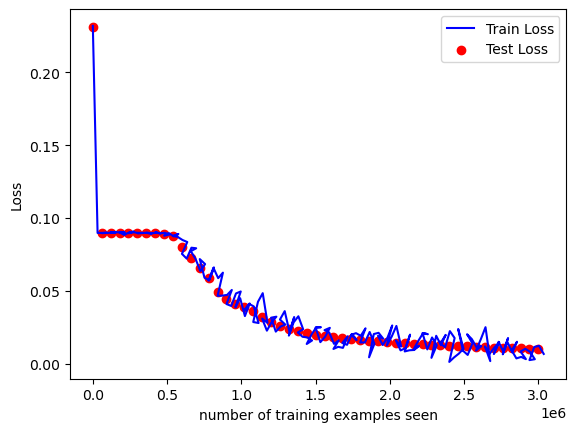

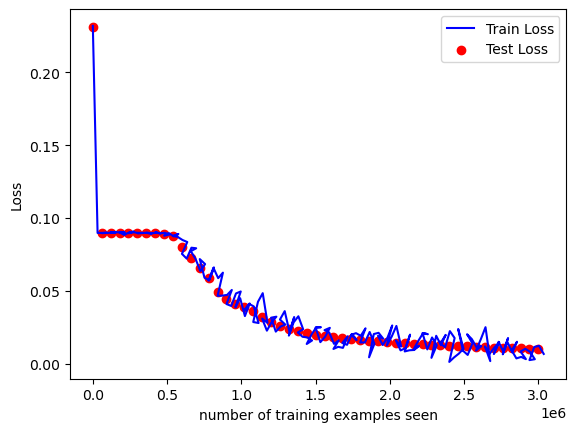

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Loss')
fig